In [30]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

In [31]:
class SimpleSignal (torch.utils.data.Dataset):
    def __init__(self, N=1000, T=100):
        super(SimpleSignal, self).__init__()
        self.N = N
        self.T = T
        self.data, self.labels = self.generate_data()
        self.train_ix, self.test_ix = self.get_ix_splits()
        
    def __getitem__(self, ix):
        return self.data[ix], self.labels[ix]
    
    def __len__(self):
        return len(self.data)
    
    def get_ix_splits(self):
        split_props = [0.8, 0.1, 0.1]
        indices = range(len(self.data))
        split_points = [int(len(self.data) * i) for i in split_props]
        
        train_ix = np.random.choice(indices, 
                                   split_points[0],
                                   replace = False)
        test_ix = np.random.choice(list(set(indices) - set(train_ix)),
                                  split_points[1],
                                  replace = False)
    
        return train_ix, test_ix
        
    def generate_data(self):
        
        data = []
        labels = []
        data1 = open('ItalyPowerDemand_TRAIN')
        lines1 = data1.readlines()
        data2 = open('ItalyPowerDemand_TEST')
        lines2 = data2.readlines()
        
        # EXTRACTING THE LABELS
        
        firstNumber1 = [i[0] for i in lines1]
        labels.append(firstNumber1)
        firstNumber2 = [i[0] for i in lines2]
        labels.append(firstNumber2)
        
        # adding the label lists from both training and testing 
        labels = labels[0] + labels[1]
        labels = list(map(int, labels))
        
        # convert from 1 to 0, from 2 to 1
        for i in range(len(labels)):
            if labels[i] == 1:
                labels[i] = 0
            else:
                labels[i] = 1
        
        
        # EXTRACTING THE DATA
        lines = lines1 + lines2
        
        # i is the line #
        for i in range(len(lines)):
            line = np.asarray(lines[i].split(','))
            tempData = []
            
            for j in range(1, len(line)):
                elem = float(line[1])
                tempData.append(elem)
            
            data.append(tempData)
            
        '''
        print("Raw data: ")
        for i in lines:
            print(i)
        print("Labels: ", labels)
        print()
        print("Data: ", data)
        '''
        
        dataTensor = torch.tensor(data, dtype = torch.float).unsqueeze(2)
        labelsTensor= torch.tensor(labels, dtype = torch.long)
        
        print(dataTensor)
        print(labelsTensor)
        
        return dataTensor, labelsTensor
    

In [39]:
# --- Model architecture and training ---

HIDDEN_DIMENSION = 20
N_LAYERS = 1
BATCH_SIZE = 10
N_EPOCHS = 20
LEARNING_RATE = [.001, .005, .01]

# --- Data generation parameters ---

SEQ_LENGTH = 10
N_INSTANCES = 1000
N_FEATURES = 1
N_CLASSES = 2

# training set into 10 batches 
# each has 80 objects

# --- create the dataset ---
data = SimpleSignal(T=SEQ_LENGTH, N = N_INSTANCES)


tensor([[[-0.7105],
         [-0.7105],
         [-0.7105],
         ...,
         [-0.7105],
         [-0.7105],
         [-0.7105]],

        [[-0.9930],
         [-0.9930],
         [-0.9930],
         ...,
         [-0.9930],
         [-0.9930],
         [-0.9930]],

        [[ 1.3191],
         [ 1.3191],
         [ 1.3191],
         ...,
         [ 1.3191],
         [ 1.3191],
         [ 1.3191]],

        ...,

        [[-1.2627],
         [-1.2627],
         [-1.2627],
         ...,
         [-1.2627],
         [-1.2627],
         [-1.2627]],

        [[ 0.7143],
         [ 0.7143],
         [ 0.7143],
         ...,
         [ 0.7143],
         [ 0.7143],
         [ 0.7143]],

        [[-0.5821],
         [-0.5821],
         [-0.5821],
         ...,
         [-0.5821],
         [-0.5821],
         [-0.5821]]])
tensor([0, 0, 1,  ..., 1, 1, 1])


In [40]:
# --- define the data loaders ---
train_sampler = SubsetRandomSampler(data.train_ix) # Random sampler for training indices
test_sampler = SubsetRandomSampler(data.test_ix) # Random sampler for testing indices

# drop_last = True to drop the last incomplete batch, if the dataset size is not
# divisible by the batch size
train_loader = torch.utils.data.DataLoader(dataset=data,
                                           batch_size=BATCH_SIZE, 
                                           sampler=train_sampler,
                                           shuffle=False, drop_last = True)

test_loader = torch.utils.data.DataLoader(dataset=data,
                                          batch_size=BATCH_SIZE, 
                                          sampler=test_sampler,
                                          shuffle=False, drop_last = True)

# --- define your model here ---
class RNN(nn.Module):
    def __init__(self, HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE):
        super(RNN, self).__init__()
        self.N_LAYERS = N_LAYERS
        self.BATCH_SIZE = BATCH_SIZE
        self.HIDDEN_DIMENSION = HIDDEN_DIMENSION
        self.N_CLASSES = N_CLASSES
        
        # --- define mappings here ---
        self.lstm = torch.nn.LSTM(N_FEATURES, HIDDEN_DIMENSION)       #sets up initial weight matrices
        self.out = torch.nn.Linear(HIDDEN_DIMENSION, N_CLASSES)
        #nonlinear part - tells probabilites
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, X):  #X is input data - tensor shape = (batch size, input dimension)
        # --- define forward pass here ---
        #initialize hidden state - need to do this because this is an RNN/LSTM (you use torch.nn.LSTM above)
        state = (torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION), # h_0 initial hidden state
                 torch.zeros(N_LAYERS, BATCH_SIZE, self.HIDDEN_DIMENSION)) # c_0 initial cell state
        X = torch.transpose(X, 0, 1)  #should have shape timesteps, batch_size, num features
        
        hidden, state = self.lstm(X, state)   #X is timeseries, shape is (timesteps, batch size)
        #hidden = h_t = hidden cell sate after w1 weight matrix (self.LSTM has been applied to the current cell) = this is actually vector containing all h_t's for each cell
        #state = (h_n, c_n) = h_n is hidden state that depends on all previous cells, c_n is cell state that depends on all previous cells
        output = self.out(hidden[-1])   #cell's hidden state gets passed thru w2 (out) weight matrix to produce output
        prediction = self.softmax(output)
        return prediction

In [41]:
loss_dif_lr = []
accuracy_dif_lr = []

# looping over the hidden dimensions
for i_lr in range(len(LEARNING_RATE)):
    # --- initialize the model and the optimizer ---
    model = RNN(HIDDEN_DIMENSION, N_CLASSES, N_FEATURES, N_LAYERS, BATCH_SIZE)
    optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE[i_lr]) 
    # Using the Adam optimizer - don't worry about the details, it's going to update the network's weights.
    criterion = torch.nn.CrossEntropyLoss()   #definig loss function

    # --- training the model ---
    
    loss_vector_training=[]
    accuracy_vector_training=[]
    for epoch in range(N_EPOCHS):
        loss_sum = 0
        predictions_sum = 0
        labels_sum = 0
        for i, (time_series, labels) in enumerate(train_loader): # Iterate through the training batches
            
            # --- Forward pass ---
            predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)
        
            #zero gradients, can also do model.zero_grad() in this case
            optimizer.zero_grad()   
        
            for i in range(10):
                predict = predictions[i,1]
                if predict <=.5:
                    estimate=0
                else:
                    estimate=1
                if estimate==labels[i]:
                    predictions_sum += 1
                labels_sum += 1
            
            # --- Compute gradients and update weights ---
            # criterion is the cross entropy loss function
            loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
            loss.backward(retain_graph = True)
            optimizer.step()  #updates parameters using Adam alg rather than grad descent
            loss_sum += loss.item()
            #if (i+1) % 1 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, i+1, len(train_loader), loss.item()))
        accuracy = predictions_sum/labels_sum
        loss_total = loss_sum/ 80
        accuracy_vector_training.append(accuracy)
        loss_vector_training.append(loss_total)
        print('accuracy: ', accuracy)
        print ('Loss for each Epoch:','Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, N_EPOCHS, loss_total))
    loss_dif_lr.append(loss_vector_training)
    accuracy_dif_lr.append(accuracy_vector_training)

accuracy:  0.5551724137931034
Loss for each Epoch: Epoch [1/20], Loss: 0.7497
accuracy:  0.5908045977011495
Loss for each Epoch: Epoch [2/20], Loss: 0.7287
accuracy:  0.6195402298850575
Loss for each Epoch: Epoch [3/20], Loss: 0.7017
accuracy:  0.6816091954022988
Loss for each Epoch: Epoch [4/20], Loss: 0.6674
accuracy:  0.635632183908046
Loss for each Epoch: Epoch [5/20], Loss: 0.6908
accuracy:  0.6781609195402298
Loss for each Epoch: Epoch [6/20], Loss: 0.6633
accuracy:  0.6218390804597701
Loss for each Epoch: Epoch [7/20], Loss: 0.6848
accuracy:  0.5896551724137931
Loss for each Epoch: Epoch [8/20], Loss: 0.7025
accuracy:  0.6609195402298851
Loss for each Epoch: Epoch [9/20], Loss: 0.6601
accuracy:  0.664367816091954
Loss for each Epoch: Epoch [10/20], Loss: 0.6662
accuracy:  0.6770114942528735
Loss for each Epoch: Epoch [11/20], Loss: 0.6559
accuracy:  0.6482758620689655
Loss for each Epoch: Epoch [12/20], Loss: 0.6668
accuracy:  0.667816091954023
Loss for each Epoch: Epoch [13/20]

In [44]:
#validation - no data for this, so skipping this step

#testing
loss_vector_testing=[]
accuracy_vector_testing=[]
for i, (time_series, labels) in enumerate(test_loader): # Iterate through the testing set, 10 timeseries in 10 batches (100 timeseries total)
        predictions_sum = 0
        labels_sum = 0
        loss_sum = 0
        predictions = model(time_series)   #time_series has to have shape (batch size=10, input dimension=1)
        
        for i in range(10):
            predict = predictions[i,1]
            if predict <=.5:
                estimate=0
            else:
                estimate=1
            if estimate==labels[i]:
                predictions_sum += 1
            labels_sum += 1
        loss = criterion(predictions, labels)    #predictions shape is (10, 2), labels shape is (10)
        loss_sum += loss.item()
        accuracy = predictions_sum/labels_sum
        loss_vector_testing.append(loss_sum)
        accuracy_vector_testing.append(accuracy)
        print('accuracy: ', accuracy)
        print('loss: ', loss_sum)


accuracy:  0.7
loss:  0.6650964021682739
accuracy:  0.8
loss:  0.5520765781402588
accuracy:  0.8
loss:  0.5345410108566284
accuracy:  0.8
loss:  0.49401360750198364
accuracy:  0.8
loss:  0.6222198009490967
accuracy:  0.6
loss:  0.6146866083145142
accuracy:  0.7
loss:  0.6328721642494202
accuracy:  0.9
loss:  0.45899248123168945
accuracy:  0.8
loss:  0.596112072467804
accuracy:  0.6
loss:  0.604731559753418


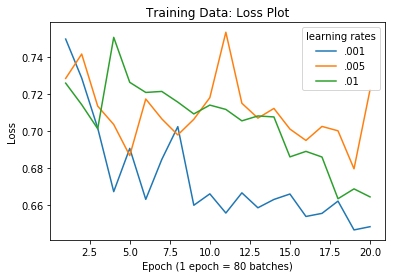

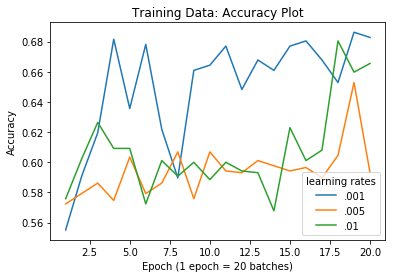

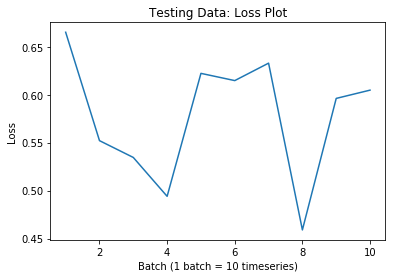

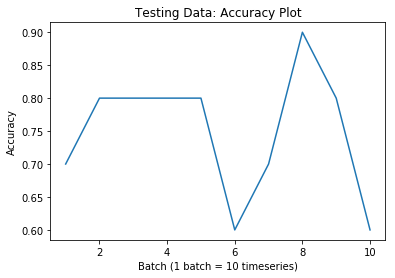

In [45]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

epochs_vector = [i for i in range(1, 21)]
plt.plot(epochs_vector, loss_dif_lr[0])
plt.plot(epochs_vector, loss_dif_lr[1])
plt.plot(epochs_vector, loss_dif_lr[2])
plt.legend(['.001', '.005', '.01'], loc='upper right', title='learning rates')
plt.title('Training Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch (1 epoch = 80 batches)')
plt.show();

plt.plot(epochs_vector, accuracy_dif_lr[0])
plt.plot(epochs_vector, accuracy_dif_lr[1])
plt.plot(epochs_vector, accuracy_dif_lr[2])
plt.legend(['.001', '.005','.01'], loc='lower right', title="learning rates")
plt.title('Training Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch (1 epoch = 20 batches)')
plt.show();

batch_vector = [i for i in range(1, 11)]
plt.plot(batch_vector, loss_vector_testing)
plt.title('Testing Data: Loss Plot')
plt.ylabel('Loss')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .3, .646])
plt.show();

plt.plot(batch_vector, accuracy_vector_testing)
plt.title('Testing Data: Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Batch (1 batch = 10 timeseries)')
#plt.axis([0, 10, .654, 1.022])
plt.show();